In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import cv2
import pandas as pd

from collections import defaultdict
from matplotlib import pyplot as plt

# This is needed since the notebook is stored in the object_detection folder.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
# paths to main folders: with frozen graph, with classes labels, 
# with all shelves images and with data
PATH_TO_MODEL = 'pack_detector/models/faster_rcnn_nas/research/object_detection/frozen_inference_graph.pb'
PATH_TO_LABELS = 'pack_detector/data/pack.pbtxt'
PATH_TO_IMAGES = 'images/'
PATH_TO_DATA = 'data/'
NUM_CLASSES = 2

In [4]:
droids = pd.read_pickle(f'{PATH_TO_DATA}droids_df.pkl')
droids = droids[~droids.is_train]
droids.head()

,class,fileName,height,width,xmax,xmin,ymax,ymin,is_train,category
2,bb8,BB-8_3,480,480,443,23,480,155,False,1
4,bb8,BB-8_5,332,800,442,332,332,208,False,1
7,bb8,BB-8_8,332,800,541,116,332,43,False,1
9,bb8,BB-8_10,683,1024,696,354,622,168,False,1
10,bb8,BB-8_11,402,634,257,144,385,233,False,1


In [5]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
# load categories (we have only 1 category pack)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, 
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def run_inference_for_single_image(image, image_tensor, sess, tensor_dict):
    # Run inference
    expanded_dims = np.expand_dims(image, 0)
    feed_dict={image_tensor: expanded_dims}
    print('feed_dict:', len(expanded_dims))
    output_dict = sess.run(tensor_dict, feed_dict)
    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

In [8]:
def run_inference_for_image_part(image_tensor, sess, tensor_dict, 
                                 image, cutoff, ax0, ay0, ax1, ay1):
    boxes = []
    im = image[ay0:ay1, ax0:ax1]
    h, w, c = im.shape
    output_dict = run_inference_for_single_image(im, image_tensor, sess, tensor_dict)
    for i in range(100):
        if output_dict['detection_scores'][i] < cutoff:
            break
        y0, x0, y1, x1, score = *output_dict['detection_boxes'][i], \
                                output_dict['detection_scores'][i]
        x0, y0, x1, y1, score = int(x0*w), int(y0*h), \
                                int(x1*w), int(y1*h), \
                                int(score * 100)
        boxes.append((x0+ax0, y0+ay0, x1+ax0, y1+ay0, score))
    return boxes

In [9]:
def run_inference_for_image_part_pcnt(image_tensor, sess, tensor_dict, 
                                 image, cutoff, p_ax0, p_ay0, p_ax1, p_ay1):
    h, w, c = image.shape
    max_x, max_y = w-1, h-1
    return run_inference_for_image_part(
                                image_tensor, sess, tensor_dict, 
                                image, cutoff, 
                                int(p_ax0*max_x), int(p_ay0*max_y), 
                                int(p_ax1*max_x), int(p_ay1*max_y))

In [10]:
def display_image_with_boxes(image, boxes, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x0, y0, x1, y1, score in boxes:
        image = cv2.rectangle(image, (x0, y0), (x1, y1), (0,255,0), 5)
    if p_x0 != 0 or p_y0 !=0 or p_x1 != 1 or p_y1 != 1:
        h, w, c = image.shape
        max_x, max_y = w-1, h-1
        image = cv2.rectangle(image, 
                              (int(p_x0*max_x), int(p_y0*max_y)), 
                              (int(p_x1*max_x), int(p_y1*max_y)), (0,0,255), 5)
    plt.figure(figsize=(14, 14))
    plt.imshow(image)

In [11]:
def initialize_graph():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name
                        for op in ops
                        for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes',
                'detection_scores', 'detection_classes',
                'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    return image_tensor, tensor_dict

# starting function for inference
def do_inference_and_display(file, cutoff, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}.jpg')
            print(image.shape)
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(image_tensor, 
                                                      sess, tensor_dict, 
                                                      image, 
                                                      cutoff, 
                                                      p_x0, p_y0, p_x1, p_y1)
            display_image_with_boxes(image, boxes, p_x0, p_y0, p_x1, p_y1)

(432, 634, 3)
feed_dict: 1


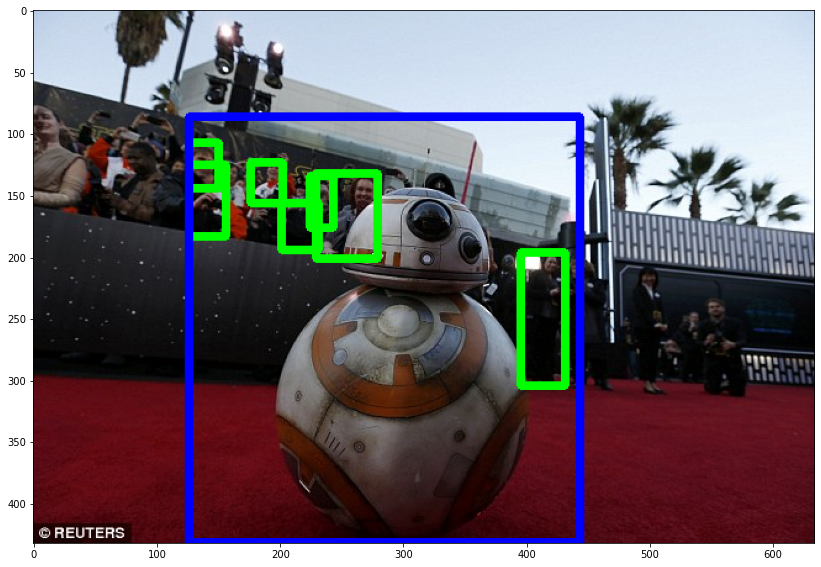

In [12]:
# to save time let's start with really hard image
do_inference_and_display('BB-8_2', 0.5, 0.2, 0.2, 0.7, 1)
# it works not bad, but not with 100% quality